# Momento de Retroalimentación:
## Módulo 2 Implementación de un modelo de deep learning.

Antonio Oviedo Paredes A01752114

Liga de Google colab: https://colab.research.google.com/drive/1su4Xly3KgKEDP5lfKiZKSnzO7azaQ_NU?usp=sharing

## 1. Introducción

###  Desarrollo de un modelo de Red Neuronal Convolucional para el reconocimiento de imágenes en lenguaje de señas

La comunicación es una parte fundamental de la vida humana, y el lenguaje de señas desempeña un papel crucial en facilitar la interacción para aquellas personas con discapacidades auditivas. Aunque el lenguaje de señas es un medio efectivo de expresión, su comprensión por parte de sistemas basados en inteligencia artificial plantea un desafío significativo. Este notebook aborda específicamente el problema del reconocimiento de imágenes en lenguaje de señas de números mediante la aplicación de modelos de Redes Neuronales Convolucionales.

El reconocimiento preciso de gestos y señas en imágenes de lenguaje de señas es una tarea compleja debido a la variabilidad inherente en la posición de las manos, la velocidad del gesto y la presencia de gestos simultáneos. La falta de herramientas efectivas para traducir estos gestos crea barreras en la comunicación para la comunidad de personas con discapacidad auditiva. Este notebook propone abordar este problema desarrollando un modelo de CNN capaz de reconocer con precisión los signos de algunas señas en imágenes estáticas.

La importancia de superar las barreras en la comunicación para las personas con discapacidad auditiva no puede subestimarse. El desarrollo de un sistema preciso y eficiente para el reconocimiento de imágenes en lenguaje de señas tiene implicaciones directas en la mejora de la calidad de vida de esta comunidad, facilitando su participación en diversos entornos sociales y profesionales. Además, este trabajo demuestra cómo las tecnologías emergentes pueden tener un impacto positivo y significativo en la inclusión y accesibilidad.

## 2. Datos

### 2.1 Descarga de los datos

In [3]:
# !mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets list

ref                                                           title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/customer-shopping-trends-dataset            Customer Shopping Trends Dataset                146KB  2023-10-05 06:45:37          23848        487  1.0              
alexq1111/imdb-top-rated-english-movies                       IMDb Top Rated English Movies                     4KB  2023-11-10 12:33:08            592         21  1.0              
samyakb/student-stress-factors                                Student stress factors                           887B  2023-11-02 12:42:11           3354         68  0.9411765        
joebeachcapital/30000-spotify-songs                           30000 Spotify Songs         

In [5]:
!kaggle datasets download -d maneesh99/signs-detection-dataset

 56% 5.00M/8.88M [00:00<00:00, 36.5MB/s]
100% 8.88M/8.88M [00:00<00:00, 49.7MB/s]


In [6]:
!unzip signs-detection-dataset.zip

Archive:  signs-detection-dataset.zip
  inflating: Signs_Data_Testing.h5   
  inflating: Signs_Data_Training.h5  


In [7]:
import h5py

train_data = h5py.File('Signs_Data_Training.h5')
test_data = h5py.File('Signs_Data_Testing.h5')

### 2.2 Preparación de los datos


In [8]:
import pandas as pd
import numpy as np

# Extract training and testing data from the dataset
X_train = np.array(train_data['train_set_x'])
y_train = np.array(train_data['train_set_y'])
X_test = np.array(test_data['test_set_x'])
y_test = np.array(test_data['test_set_y'])

# Reshape the input data to the correct form
X_train = X_train.reshape(1080, -1)
X_train = pd.DataFrame(X_train)

X_test = X_test.reshape(120, -1)
X_test = pd.DataFrame(X_test)

# Create DataFrames for training and testing labels
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# Rename the label columns
y_train.columns = ['Label']
y_test.columns = ['Label']

# Reshape the input data to the shape of 64x64x3 images
X_train = X_train.values.reshape(1080, 64, 64, 3)
X_test = X_test.values.reshape(120, 64, 64, 3)

# Dimensions
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((1080, 64, 64, 3), (1080, 1), (120, 64, 64, 3), (120, 1))

Class:  Label    5
Name: 29, dtype: int64


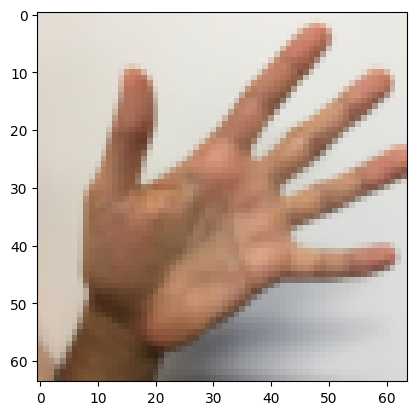

In [9]:
import matplotlib.pyplot as plt

# Display image
pi = 29
plt.imshow(X_train[pi])
print("Class: ", y_train.iloc[pi])


In [10]:
# One hot encode output
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

## 3. Modelo


### 3.1 Arquitectura del modelo inicial

Capas convolucionales y max pooling: La secuencia de capas convolucionales y max pooling se utiliza para extraer características relevantes de las imágenes de señas. Las capas de max pooling ayudan a reducir la dimensionalidad y a focalizarse en las características más importantes, lo que contribuye a mejorar la eficiencia computacional y a prevenir el overfitting.

Número creciente de filtros: La progresión en el número de filtros (16, 32, 64, 128) en las capas convolucionales refleja una jerarquía de complejidad creciente. Las capas iniciales pueden aprender menos características simples, como bordes y colores, mientras que las capas posteriores pueden capturar un mayor número de patrones más complejos y abstractos.

Capas fully connected con dropout: Después de extraer características relevantes con las capas convolucionales, se utilizan capas totalmente conectadas para realizar la clasificación final. La inclusión de capas de dropout ayuda a prevenir el overfitting al desactivar aleatoriamente un porcentaje de neuronas durante el entrenamiento.

Capa de salida softmax: La capa de salida con función de activación softmax es apropiada para problemas de clasificación multiclase. En este caso, se asume que hay seis clases correspondientes a las señas del 0 al 5.


In [11]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout

# Define a sequential model
model = Sequential([
    Input(shape=[64, 64, 3]),
    Conv2D(filters=16, kernel_size=5, activation="relu"),
    MaxPooling2D(2),
    Conv2D(filters=32, kernel_size=5, activation="relu"),
    MaxPooling2D(2),
    Conv2D(filters=64, kernel_size=4, activation="relu"),
    MaxPooling2D(2),
    Conv2D(filters=128, kernel_size=3, activation="relu"),
    MaxPooling2D(2),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(6, activation="softmax")
])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        32832     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 64)          0

### 3.2 Entrenamiento del modelo

In [12]:
# Adam optimizer with a 0.0001 learning rate
opt = keras.optimizers.Adam(learning_rate=.0001)
# Sparse Categorical Accuracy metric
acc = keras.metrics.SparseCategoricalAccuracy()
# Mean Absolute Error metric
mae = keras.metrics.MeanAbsoluteError()

# Compile the model with the specified optimizer, loss function, and metrics
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=[acc, mae])

# Train the model on the training data with validation split, using 30 epochs
history = model.fit(X_train, y_train, validation_split=0.1, epochs=30)

Epoch 1/30
31/31 [==============================] - 6s 149ms/step - loss: 14.7643 - sparse_categorical_accuracy: 0.1728 - mean_absolute_error: 2.3666 - val_loss: 1.9641 - val_sparse_categorical_accuracy: 0.1759 - val_mean_absolute_error: 2.5895
Epoch 2/30
31/31 [==============================] - 6s 190ms/step - loss: 3.1830 - sparse_categorical_accuracy: 0.1770 - mean_absolute_error: 2.3666 - val_loss: 1.7608 - val_sparse_categorical_accuracy: 0.2500 - val_mean_absolute_error: 2.5895
Epoch 3/30
31/31 [==============================] - 5s 155ms/step - loss: 2.2888 - sparse_categorical_accuracy: 0.1780 - mean_absolute_error: 2.3666 - val_loss: 1.7314 - val_sparse_categorical_accuracy: 0.2685 - val_mean_absolute_error: 2.5895
Epoch 4/30
31/31 [==============================] - 4s 144ms/step - loss: 2.0729 - sparse_categorical_accuracy: 0.1739 - mean_absolute_error: 2.3666 - val_loss: 1.7711 - val_sparse_categorical_accuracy: 0.2407 - val_mean_absolute_error: 2.5895
Epoch 5/30
31/31 [=====

### 3.3 Análisis del modelo

El rendimiento del modelo presentado, con una precisión de clasificación baja, sugiere que la arquitectura actual podría ser demasiado compleja para el conjunto de datos de imágenes de señas del 1 al 5 proporcionado. La baja precisión indica dificultades en la clasificación de las señas en el conjunto de prueba, y las diferencia entre la precisión de entrenamiento y validación sugiere un posible sobreajuste del modelo al conjunto de entrenamiento.

Una de las posibles causas de este problema podría ser la complejidad excesiva de la arquitectura actual, lo que podría llevar al modelo a memorizar el conjunto de entrenamiento en lugar de aprender patrones generales. Para abordar esto, se podría considerar la reducción de la complejidad del modelo, disminuyendo el número de capas y/o parámetros.

En resumen, se sugiere realizar ajustes en la arquitectura, experimentar con diferentes tasas de dropout. Estos cambios podrían contribuir a mejorar la capacidad del modelo para reconocer eficazmente las señas en imágenes y disminuir el sobreajuste del modelo.

<Axes: title={'center': 'Loss vs Epoch'}>

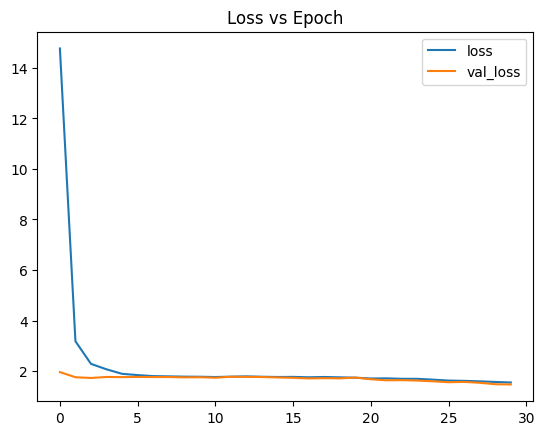

In [13]:
# Create a DataFrame from the training history
df = pd.DataFrame(history.history)

# Training loss and validation loss over epochs
df.plot(y=["loss", "val_loss"], title="Loss vs Epoch")


<Axes: title={'center': 'Sparse Categorical Accuracy vs Epoch'}>

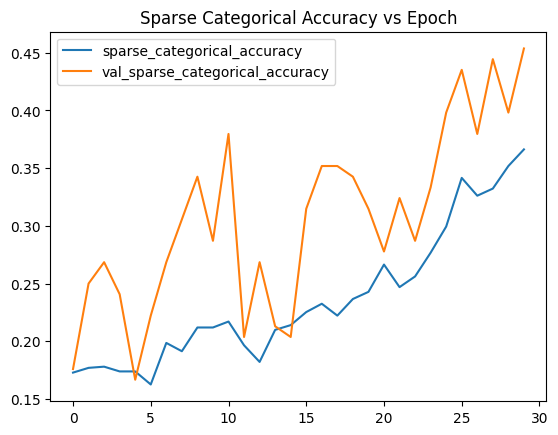

In [14]:
# Training sparse categorical accuracy and validation sparse categorical accuracy over epochs
df.plot(y=["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"], title="Sparse Categorical Accuracy vs Epoch")

In [16]:
loss, accuracy, mae = model.evaluate(X_test, y_test)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"MAE: {mae:.2f}")

4/4 [==============================] - 0s 92ms/step - loss: 1.4488 - sparse_categorical_accuracy: 0.4917 - mean_absolute_error: 2.3889
Loss: 1.45
Accuracy: 0.49
MAE: 2.39


## 4. Ajuste del modelo

### 4.1 arquitectura mejorada del modelo

Se redujo el número de capas convolucionales de cuatro a tres, con filtros ajustados a 32, 64 y 128 en sucesión. Este cambio tiene la intención de simplificar la arquitectura para adaptarse mejor al conjunto de datos de imágenes de señas, mitigando posibles problemas de overfitting asociados con la complejidad inicial.

Adicionalmente, se ha eliminado una capa fully connected. Este ajuste busca evitar complejidades innecesarias que podrían conducir al overfitting. La tasa de dropout se ha mantenido en 0.5 para contrarrestar cualquier indicio de overfitting que pueda surgir durante el entrenamiento.

Por otra parte se redujo el número de epocas ya que se observó que a partir de la epaca 15 el modelo comenzaba a presentar overfitting.

En resumen, estas adaptaciones buscan equilibrar la complejidad del modelo para mejorar su capacidad de generalización, manteniendo al mismo tiempo la efectividad en la clasificación de señas. La experimentación iterativa sigue siendo fundamental para ajustar la arquitectura y optimizar el rendimiento del modelo en la tarea específica de reconocimiento de señas.

In [40]:
better_model = Sequential([
    Input(shape=[64, 64, 3]),
    Conv2D(filters=32, kernel_size=5, activation="relu"),
    MaxPooling2D(2),
    Conv2D(filters=64, kernel_size=4, activation="relu"),
    MaxPooling2D(2),
    Conv2D(filters=128, kernel_size=3, activation="relu"),
    MaxPooling2D(2),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(6, activation="softmax")
])

better_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 27, 27, 64)        32832     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 5, 5, 128)        

### 4.2 Entrenamiento del modelo mejorado

In [41]:
# Adam optimizer with a 0.0001 learning rate
b_opt = keras.optimizers.Adam(learning_rate=.0001)
# Sparse Categorical Accuracy metric
b_acc = keras.metrics.SparseCategoricalAccuracy()
# Mean Absolute Error metric
b_mae = keras.metrics.MeanAbsoluteError()

# Compile the model with the specified optimizer, loss function, and metrics
better_model.compile(optimizer=b_opt, loss='sparse_categorical_crossentropy', metrics=[b_acc, b_mae])

# Train the model on the training data with validation split, using 15 epochs
b_history = better_model.fit(X_train, y_train, validation_split=0.1, epochs=15)

Epoch 1/15
31/31 [==============================] - 11s 326ms/step - loss: 7.8340 - sparse_categorical_accuracy: 0.1770 - mean_absolute_error: 2.3666 - val_loss: 1.6772 - val_sparse_categorical_accuracy: 0.3241 - val_mean_absolute_error: 2.5895
Epoch 2/15
31/31 [==============================] - 8s 248ms/step - loss: 1.7314 - sparse_categorical_accuracy: 0.2531 - mean_absolute_error: 2.3666 - val_loss: 1.5499 - val_sparse_categorical_accuracy: 0.4907 - val_mean_absolute_error: 2.5895
Epoch 3/15
31/31 [==============================] - 10s 320ms/step - loss: 1.5601 - sparse_categorical_accuracy: 0.3642 - mean_absolute_error: 2.3666 - val_loss: 1.3219 - val_sparse_categorical_accuracy: 0.5370 - val_mean_absolute_error: 2.5895
Epoch 4/15
31/31 [==============================] - 10s 317ms/step - loss: 1.4146 - sparse_categorical_accuracy: 0.4362 - mean_absolute_error: 2.3666 - val_loss: 1.1688 - val_sparse_categorical_accuracy: 0.5463 - val_mean_absolute_error: 2.5895
Epoch 5/15
31/31 [===

### 4.3 Análisis del modelo mejorado

<Axes: title={'center': 'Loss vs Epoch'}>

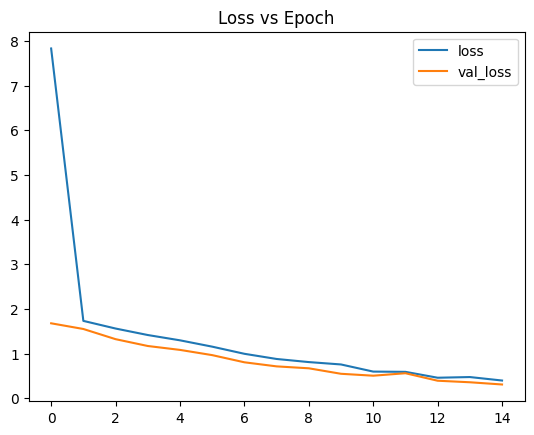

In [42]:
# Create a DataFrame from the training history
b_df = pd.DataFrame(b_history.history)

# Training loss and validation loss over epochs
b_df.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

<Axes: title={'center': 'sparse_categorical_accuracy vs Epoch'}>

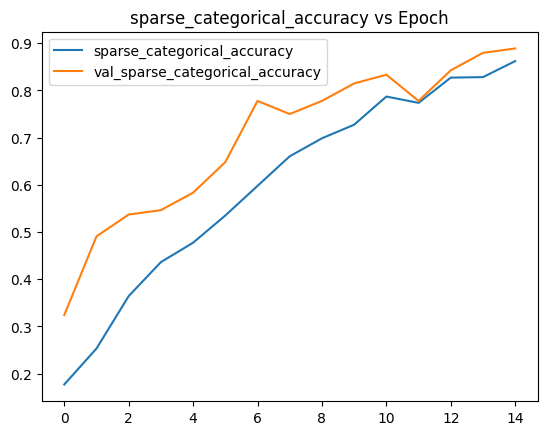

In [43]:
# Training sparse categorical accuracy and validation sparse categorical accuracy over epochs
b_df.plot(y=["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"], title="sparse_categorical_accuracy vs Epoch")

## 5. Resultados


### 5.1 Métricas del modelo

El primer modelo, aunque implementaba una arquitectura más compleja, mostró signos de overfitting, con una precisión de solo 0.49 en el conjunto de prueba. Estos resultados indicaban dificultades para generalizar patrones a nuevas instancias de señas y sugerían que la complejidad del modelo podría haber sido excesiva para el conjunto de datos proporcionado.

El modelo tuvo una simplificación significativa en su arquitectura, y los resultados indican una mejora sustancial en el rendimiento. La matriz de confusión muestra una clasificación precisa de las seis clases de señas, con una precisión global del 92%. El loss ha disminuido considerablemente a 0.25, indicando una mejor capacidad del modelo para ajustarse a los datos de entrenamiento. La precisión del modelo se ha elevado significativamente al 92%, y el error absoluto medio se ha mantenido constante en 2.39.

El análisis del informe de clasificación revela que el modelo es capaz de reconocer todas las clases con precisión, destacando la mejora en la capacidad de generalización. La precisión, recall y f1-score se encuentran en niveles aceptables para todas las clases, indicando una mejora generalizada en la capacidad del modelo para clasificar señas. Este rendimiento sugiere que la simplificación y ajuste en la arquitectura del modelo han resultado en beneficios tangibles, mejorando la capacidad de generalización y, por ende, la precisión en la tarea de reconocimiento de señas.

4/4 [==============================] - 0s 105ms/step


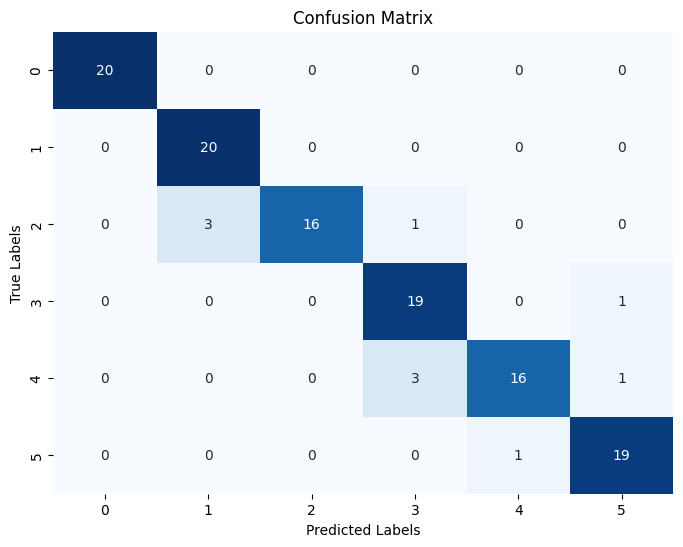


Loss: 0.25
Accuracy: 0.92
MAE: 2.39

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.87      1.00      0.93        20
           2       1.00      0.80      0.89        20
           3       0.83      0.95      0.88        20
           4       0.94      0.80      0.86        20
           5       0.90      0.95      0.93        20

    accuracy                           0.92       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.92      0.92       120


Overall Accuracy: 0.92


In [49]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Evaluate the model
b_loss, b_accuracy, b_mae = better_model.evaluate(X_test, y_test)

# Model predictions on the test set
y_pred = better_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print additional metrics
print()
print(f"Loss: {b_loss:.2f}")
print(f"Accuracy: {b_accuracy:.2f}")
print(f"MAE: {b_mae:.2f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Print overall accuracy
print(f"\nOverall Accuracy: {accuracy_score(y_test, y_pred_classes):.2f}")


### 5.2 Predicciones del modelo



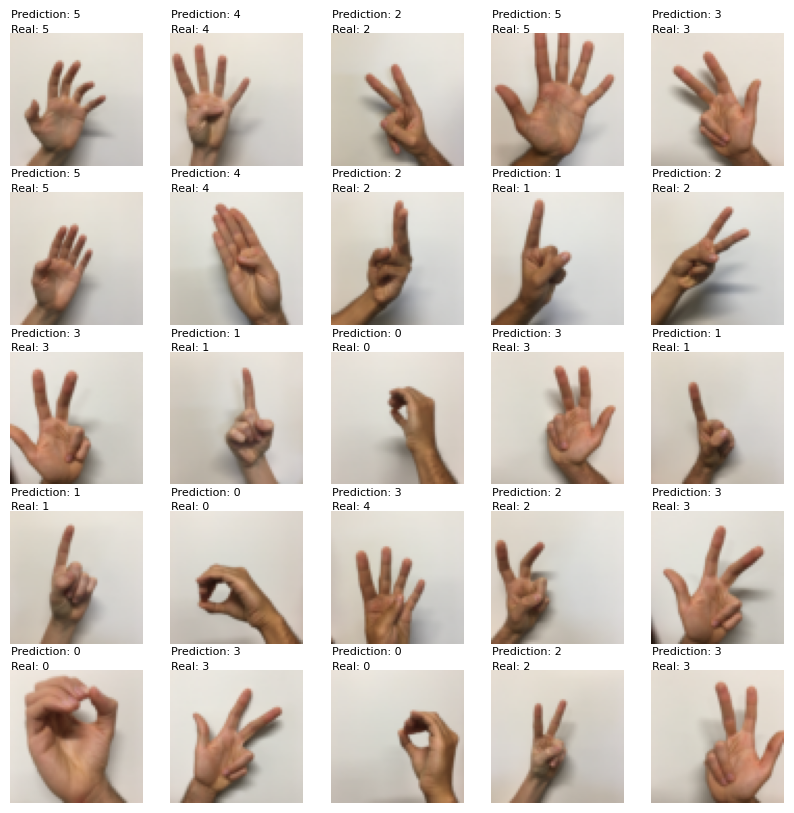

In [94]:
# Define the dimensions of the grid
rows = 5
columns = 5

# Create a figure and axes using subplots
fig, axs = plt.subplots(rows, columns, figsize=(10, 10))

# Iterate through the image paths and display them in the grid
for i in range(rows):
    for j in range(columns):
        image_index = i * columns + j + 20
        if image_index < len(y_pred):
            # Display the image in the corresponding axes
            axs[i, j].imshow(X_test[image_index])
            axs[i, j].text(0, -1, f'Real: {y_test.iloc[image_index]["Label"]}', fontsize=8)
            axs[i, j].text(0, -8, f'Prediction: {np.argmax(y_pred[image_index])}', fontsize=8)
            axs[i, j].axis('off')

# Show the grid of images
plt.show()


## 6. Conclusiones

En conclusión, al abordar el desafío del reconocimiento de imágenes de lenguaje de señas mediante modelos de inteligencia artificial, se evidenció la importancia de encontrar un equilibrio entre la complejidad del modelo y la capacidad de generalización. El primer modelo, con una arquitectura más compleja, mostró signos de overfitting y un rendimiento limitado en la tarea de clasificación de señas.

Con el objetivo de mejorar estos resultados, se propuso un segundo modelo caracterizado por una arquitectura más simplificada. Este ajuste condujo a una mejora significativa, evidenciada por una matriz de confusión precisa y métricas de evaluación aceptables para todas las clases de señas. La precisión global alcanzó 92% de precisión, indicando una mayor capacidad de generalización y confianza en la clasificación de señas.

En resumen, la adaptación y simplificación de la arquitectura del modelo resultaron en beneficios, demostrando que la efectividad en tareas específicas como el reconocimiento de señas puede mejorar significativamente al encontrar un equilibrio adecuado en la complejidad del modelo.